# Analysis of 2019 National High School Exam Data (ENEM) in Brazil (1)

This notebook is my personal playground in which I am applying some machine learning techniques to predict student outcomes on the 2019 National High School Exam (Exame Nacional do Ensino Médio, or ENEM). The dataset is from <a href="https://www.kaggle.com/saraivaufc/enem-2019">Kaggle</a>.

This notebook focuses on basic descriptives and feature engineering. See the other notebook on the same repo for modelling exercises.

In [1]:
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.5f' % x)
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
data = pd.read_csv("data/MICRODADOS_ENEM_2019.csv", encoding = 'latin-1', delimiter = ';')
data.shape

(5095270, 136)

In [2]:
data['NU_INSCRICAO'].nunique() == data.shape[0]

True

In [3]:
# outcomes of interest
data[['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO']].describe()

,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO
count,3710433.00000,3923145.00000,3923145.00000,3710433.00000,3923144.00000
mean,477.82409,507.24866,520.51766,523.12412,571.18835
std,76.09774,82.41163,64.15065,109.06369,188.76327
min,0.00000,0.00000,0.00000,0.00000,0.00000
25%,417.80000,447.90000,483.50000,435.10000,480.00000
50%,470.30000,510.60000,526.20000,501.10000,580.00000
75%,533.20000,566.60000,565.30000,597.80000,680.00000
max,860.90000,835.10000,801.70000,985.50000,1000.00000


In [4]:
data[['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO']].isnull().sum()

NU_NOTA_CN         1384837
NU_NOTA_CH         1172125
NU_NOTA_LC         1172125
NU_NOTA_MT         1384837
NU_NOTA_REDACAO    1172126
dtype: int64

As you can see, there are over 5 million records in this data. The available information includes individual student demographics, academic background, and some household survey answers. The test outcomes are numeric scores on the Natural Science, Humanities, Language, Mathematics, and the essay sections. Based on <a href="http://prouniportal.mec.gov.br/">this</a>, it does appear that participants who earn an average score of 450 or more on the first four sections and a non-zero score on the essay are eligible for a college scholarship program, so let us use this definition to create a binary outcome for classification. 

In [5]:
data['objective_avg'] = (data['NU_NOTA_CN'] + data['NU_NOTA_CH'] + data['NU_NOTA_LC'] + data['NU_NOTA_MT'])/4
data['prouni_pass'] = 0
data.loc[(data['objective_avg'] >= 450) & (data['NU_NOTA_REDACAO'] > 0), 'prouni_pass'] = 1
data['prouni_pass'].value_counts()

1    2820874
0    2274396
Name: prouni_pass, dtype: int64

A bit more than a half of all participants pass, which seems like a nice balance. In the next step, let us limit the data to only those variables that will be relevant for our analysis.

In [6]:
data2 = data[['NU_INSCRICAO', 'CO_MUNICIPIO_RESIDENCIA', 'NU_IDADE', 'TP_SEXO', 'TP_ESTADO_CIVIL',
             'TP_COR_RACA', 'TP_NACIONALIDADE', 'TP_ST_CONCLUSAO', 'TP_ANO_CONCLUIU',
             'TP_ESCOLA', 'TP_ENSINO', 'IN_TREINEIRO', 'CO_MUNICIPIO_ESC',
             'TP_DEPENDENCIA_ADM_ESC', 'TP_LOCALIZACAO_ESC', 'IN_BAIXA_VISAO',
             'IN_CEGUEIRA', 'IN_SURDEZ', 'IN_DEFICIENCIA_AUDITIVA',
             'IN_SURDO_CEGUEIRA', 'IN_DEFICIENCIA_FISICA', 'IN_DEFICIENCIA_MENTAL',
             'IN_DEFICIT_ATENCAO', 'IN_DISLEXIA', 'IN_DISCALCULIA', 'IN_AUTISMO',
             'IN_VISAO_MONOCULAR', 'IN_OUTRA_DEF', 'IN_GESTANTE', 'IN_LACTANTE',
             'IN_IDOSO', 'IN_ESTUDA_CLASSE_HOSPITALAR', 'NU_NOTA_CN', 'NU_NOTA_CH',
             'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO', 'Q001', 'Q002', 'Q003',
             'Q004', 'Q005', 'Q006', 'Q007', 'Q008', 'Q009', 'Q010', 'Q011', 'Q012',
             'Q013', 'Q014', 'Q015', 'Q016', 'Q017', 'Q018', 'Q019', 'Q020', 'Q021',
             'Q022', 'Q023', 'Q024', 'Q025', 'prouni_pass']]

data2.columns = ['id', 'residency', 'age', 'sex', 'marital_status',
                 'race', 'nationality', 'hs_completion', 'hs_gradyear',
                 'hs_type', 'hs_mode', 'test_intent', 'hs_municipality',
                 'hs_control', 'hs_locality', 'ds_vision', 'ds_blind',
                 'ds_deaf', 'ds_hear', 'ds_blind_deaf', 'ds_physical_disab',
                 'ds_mental_disab', 'ds_adhd', 'ds_dyslex', 'ds_dyscalc',
                 'ds_autism', 'ds_monocular', 'ds_other', 'pregnant', 'breastfeed',
                 'elderly', 'hospitalized', 'score_science', 'score_humanities',
                 'score_language', 'score_math', 'score_essay', 'father_educ',
                 'mother_educ', 'father_occup', 'mother_occup', 'hh_members',
                 'hh_income', 'hh_domemployee', 'hh_bath', 'hh_bed', 'hh_car',
                 'hh_motorcycle', 'hh_fridge', 'hh_freezer', 'hh_wash', 'hh_dry',
                 'hh_microwave', 'hh_dishwash', 'hh_vacuum', 'hh_color', 'hh_dvd',
                 'hh_cable', 'hh_cell', 'hh_landline', 'hh_comp', 'hh_web', 'prouni_pass']

In [7]:
 data2.to_csv('cleaned_int.csv')

## Descriptives

I include some descriptive statistics on the exam data below. The general patterns are very similar to what you normally see in education research. There is very clear evidence that basic demographics such as household income and race/ethnicity are predictive of academic outcomes. It is somewhat surprising to see have the passage rate at Special Education school higher than in regular school, but remember that ENEM is not a mandatory test, so it is likely it is been attempted by students who are reasonably confident in their ability to pass.

In [8]:
data = pd.read_csv('cleaned_int.csv')

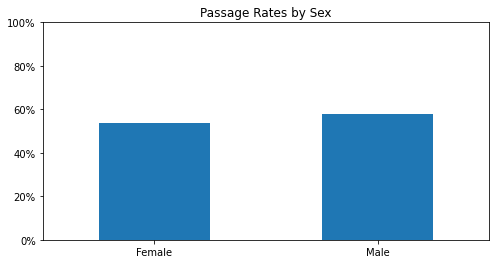

In [9]:
data['sex'] = data['sex'].map({'F': 'Female', 'M': 'Male'})
plt.figure(figsize = (8, 4))
data.groupby('sex')['prouni_pass'].agg(np.mean).plot(kind = 'bar', rot = False)
plt.title("Passage Rates by Sex")
plt.xlabel("")
plt.ylim(0, 1)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.show()

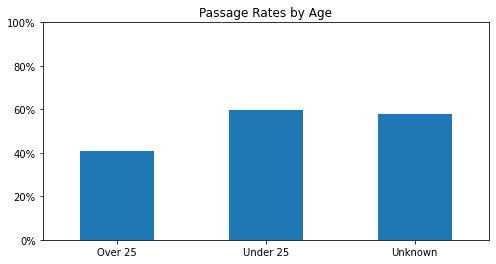

In [10]:
data.loc[data['age'] < 13, 'age_group'] = 'Unknown'
data.loc[(data['age'] > 12) & (data['age'] < 25), 'age_group'] = 'Under 25'
data.loc[data['age'] > 24, 'age_group'] = 'Over 25'
plt.figure(figsize = (8, 4))
data.groupby('age_group')['prouni_pass'].agg(np.mean).plot(kind = 'bar', rot = False)
plt.title("Passage Rates by Age")
plt.xlabel("")
plt.ylim(0, 1)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.show()

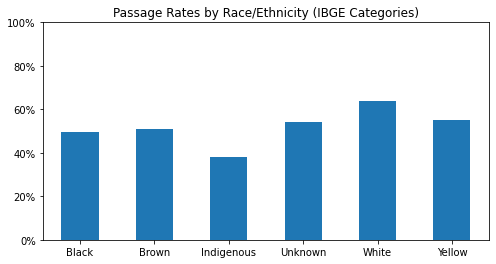

In [11]:
data['race'] = data['race'].map({0: 'Unknown', 1: 'White', 2: 'Black', 3: 'Brown', 4: 'Yellow', 5: 'Indigenous'})
plt.figure(figsize = (8, 4))
data.groupby('race')['prouni_pass'].agg(np.mean).plot(kind = 'bar', rot = False)
plt.title("Passage Rates by Race/Ethnicity (IBGE Categories)")
plt.xlabel("")
plt.ylim(0, 1)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.show()

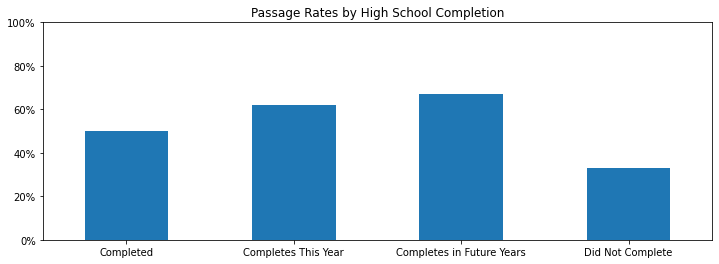

In [12]:
data['hs_completion'] = data['hs_completion'].map({1: 'Completed', 2: 'Completes This Year', 3: 'Completes in Future Years',
                                                   4: 'Did Not Complete'})
plt.figure(figsize = (12, 4))
data.groupby('hs_completion')['prouni_pass'].agg(np.mean).plot(kind = 'bar', rot = False)
plt.title("Passage Rates by High School Completion")
plt.xlabel("")
plt.ylim(0, 1)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.show()

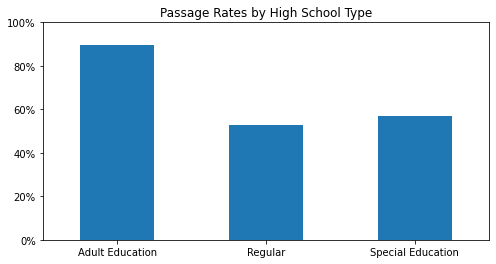

In [13]:
data['hs_type'] = data['hs_type'].map({1: 'Regular', 2: 'Special Education', 3: 'Adult Education'})
plt.figure(figsize = (8, 4))
data.groupby('hs_type')['prouni_pass'].agg(np.mean).plot(kind = 'bar', rot = False)
plt.title("Passage Rates by High School Type")
plt.xlabel("")
plt.ylim(0, 1)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.show()

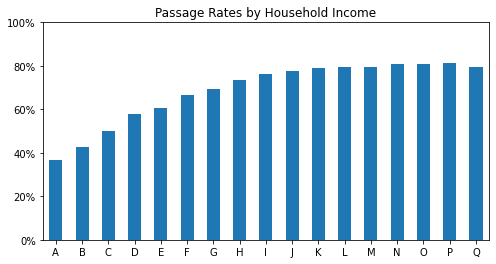

In [14]:
plt.figure(figsize = (8, 4))
data.groupby('hh_income')['prouni_pass'].agg(np.mean).plot(kind = 'bar', rot = False)
plt.title("Passage Rates by Household Income")
plt.xlabel("")
plt.ylim(0, 1)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.show()

## Feature creation

In this section, I am going through the remaining available features and transforming them for the modeling purposes. Overall, the transformations here are rather standard, at least for my field of work.

In [15]:
# extract the region from residency code => let us limit the number of units here
data['region'] = data['residency'].apply(lambda x: str(x)[0:2])
data.drop(columns = ['residency'], inplace = True)
# note that there is some notable variation in passage rates by region
data.groupby('region')['prouni_pass'].agg(np.mean)

region
11   0.47810
12   0.46099
13   0.39726
14   0.47949
15   0.47560
16   0.43517
17   0.46451
21   0.45373
22   0.50087
23   0.53052
24   0.56498
25   0.54974
26   0.54558
27   0.49381
28   0.53413
29   0.50634
31   0.60417
32   0.57888
33   0.60301
35   0.61509
41   0.60646
42   0.62080
43   0.60416
50   0.52271
51   0.48367
52   0.55871
53   0.57856
Name: prouni_pass, dtype: float64

In [16]:
# drop these => some of these have already been treated abovw, others (like high school info) are not very relevant
data.drop(columns = ['id', 'age', 'nationality', 'hs_completion', 'hs_gradyear',
                     'hs_mode', "hs_municipality", "hs_locality"], inplace = True)

In [17]:
# create indicator for any disability => a case of natural dimensionality reduction
data['disability'] = 0
for i in ['ds_vision', 'ds_blind', 'ds_deaf', 'ds_hear', 'ds_blind_deaf',
          'ds_physical_disab', 'ds_mental_disab', 'ds_adhd', 'ds_dyslex', 'ds_dyscalc',
          'ds_autism', 'ds_monocular', 'ds_other']:
    data.loc[data[i] == 1, 'disability'] = 1
data.groupby('disability')['prouni_pass'].agg(np.mean)    

disability
0   0.55400
1   0.49611
Name: prouni_pass, dtype: float64

In [18]:
# indicator for perceptual disability => a little bit more specific
data['disability_percep'] = 0
for i in ['ds_vision', 'ds_blind', 'ds_deaf', 'ds_hear', 'ds_blind_deaf']:
    data.loc[data[i] == 1, 'disability_percep'] = 1
data.groupby('disability_percep')['prouni_pass'].agg(np.mean)    

disability_percep
0   0.55401
1   0.37058
Name: prouni_pass, dtype: float64

In [19]:
# indicator for mental disability
data['disability_mental'] = 0
for i in ['ds_mental_disab', 'ds_adhd', 'ds_dyslex', 'ds_dyscalc', 'ds_autism']:
    data.loc[data[i] == 1, 'disability_mental'] = 1
data.groupby('disability_mental')['prouni_pass'].agg(np.mean)        

disability_mental
0   0.55351
1   0.60338
Name: prouni_pass, dtype: float64

In [20]:
# drop these
data.drop(columns = ['ds_vision', 'ds_blind', 'ds_deaf', 'ds_hear', 'ds_blind_deaf',
          'ds_physical_disab', 'ds_mental_disab', 'ds_adhd', 'ds_dyslex', 'ds_dyscalc',
          'ds_autism', 'ds_monocular', 'ds_other', 'pregnant', 'breastfeed', 'elderly',
            'hospitalized'], inplace = True)

In [21]:
# parents' highest level of education
data['parents_educ'] = "H"
for i in ['A', 'B', 'C', 'D', 'E', 'F', 'G']:
    data.loc[(data['mother_educ'] == i) | (data['father_educ'] == i), 'parents_educ'] = i
data.groupby('parents_educ')['prouni_pass'].agg(np.mean)       

parents_educ
A   0.30451
B   0.39435
C   0.45389
D   0.49783
E   0.58161
F   0.71045
G   0.75887
H   0.37995
Name: prouni_pass, dtype: float64

In [22]:
# parents' highest level of occupation
data['parents_occup'] = "F"
for i in ['A', 'B', 'C', 'D', 'E']:
    data.loc[(data['mother_occup'] == i) | (data['father_occup'] == i), 'parents_occup'] = i
data.groupby('parents_occup')['prouni_pass'].agg(np.mean)         

parents_occup
A   0.39139
B   0.48555
C   0.54133
D   0.68832
E   0.77105
F   0.44811
Name: prouni_pass, dtype: float64

In [23]:
# drop this
data.drop(columns = ['mother_occup', 'father_occup', 'mother_educ', 'father_educ',
                     'hh_domemployee', 'hh_bath', 'hh_bed', 'hh_car', 'hh_motorcycle',
                     'hh_fridge', 'hh_freezer', 'hh_wash', 'hh_dry', 'hh_microwave',
                     'hh_dishwash', 'hh_vacuum', 'hh_color', 'hh_dvd', 'hh_cable',
                     'hh_cell', 'hh_landline', 'hh_comp'], inplace = True)

In [24]:
# household members
data['hh_member_group'] = "One"
data.loc[(data['hh_members'] > 1) & (data['hh_members'] < 6), 'hh_member_group'] = "2 - 5"
data.loc[data['hh_members'] > 5, 'hh_member_group'] = "Over 5"
data.groupby('hh_member_group')['prouni_pass'].agg(np.mean)        

hh_member_group
2 - 5    0.56761
One      0.45193
Over 5   0.46573
Name: prouni_pass, dtype: float64

In [25]:
# drop this
data.drop(columns = ['hh_members'], inplace = True)

In [26]:
# very small sample
print(data['age_group'].value_counts())
data = data[data['age_group'] != 'Unknown']

Under 25    3965858
Over 25     1129282
Unknown         130
Name: age_group, dtype: int64


In [27]:
data = data[['sex', 'marital_status', 'race', 'hs_type',
       'test_intent', 'hs_control', 'hh_income', 'hh_web', 
        'age_group', 'region', 'disability', 'disability_percep',
        'disability_mental', 'parents_educ', 'parents_occup',
        'hh_member_group', 'score_science', 'score_humanities',
        'score_language', 'score_math', 'score_essay', 'prouni_pass']]

In [28]:
data2.to_csv('cleaned.csv', index = False)

In [29]:
###END###